In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [ ]:
from xcube.l2r.all import *

In [ ]:
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
source = untar_xxx(XURLs.MIMIC3_L2R)
source.ls()

(#11) [Path('/home/deb/.xcube/data/mimic3_l2r/info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_descriptions.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl_info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_desc.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/p_TL.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')...]

Setting some environment variables:

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# L2R Training

> Training a learning-to-rank model

In this tutorial we will train a l2r model. We will bootstrap the model using the data we prepared in tutorial [booting L2R](14_tutorial.boot_l2r.ipynb)

## Getting ready

Prepping l2r data for xcube's `L2RDataLoader`

In [ ]:
source = untar_xxx(XURLs.MIMIC3_L2R)
source.ls()

(#9) [Path('/home/deb/.xcube/data/mimic3_l2r/info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_descriptions.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl_info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_desc.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/p_TL.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl.ft')]

Note: If you don't have enough GPU/CPU memory just run the last cell of this section to load the pregenerated ones.

Here we can just load the file which contains the relevant information about the tokens, labels and their mutual-information-gain:

In [ ]:
# Cheking if you have enough memory to set device
cuda_memory = torch.cuda.get_device_properties(torch.cuda.current_device()).total_memory/1024**3
if cuda_memory < 10.: print(f"Not Enough GPU Memory (just {cuda_memory} GB), we'll use {default_device(use=False)}")
l2r_bootstrap = torch.load(source/'mimic3-9k_tok_lbl_info.pkl', map_location=default_device())

Not Enough GPU Memory (just 5.99951171875 GB), we'll use cpu


In [ ]:
test_eq(l2r_bootstrap.keys(), ['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])
toks = l2r_bootstrap.get('toks', None)
lbs = l2r_bootstrap.get('lbs', None)
info = l2r_bootstrap.get('mutual_info_jaccard', None)
for o in (toks, lbs, info): assert o is not None
test_eq(info.shape, (len(toks), len(lbs)))

`info` contains the mutual-information-gain values for the tokens and labels. In what follows we'll toss in some pandas to take a good hard look at the data before we proceed towards making xcube's `L2RDataLoader`: 

*Note:* Storing the tokens and the labels in a dataframe as `object` will take up a lot of RAM space when we prepare that `DataLoader`. So we are going to store the corresponding token and label indices instead in a dataframe called `df_l2r`. We are also going to store the tokens and the labels with their corresponding indices in seperate dataframes (this will help in quick merging for analysis).

Here we will rank the tokens for each label based on the decreasing values of the mutual-info and stack them up with mutual-info.

In [ ]:
ranked = info.argsort(descending=True, dim=0).argsort(dim=0)
info_ranked =torch.stack((info, ranked), dim=2).flatten(start_dim=1)

In [ ]:
cols = pd.MultiIndex.from_product([range(len(lbs)), ['mutual_info', 'rank']], names=['label', 'key2'])
df_l2r = pd.DataFrame(info_ranked, index=range(len(toks)), columns=cols)
df_l2r.index.name='token'

In [ ]:
df_l2r.head(3)

label        0                    1                    2              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000022    866.0    0.000011   1022.0    0.000022   1156.0   
1        0.000000  56856.0    0.000000  41420.0    0.000000  56855.0   
2        0.000000  56857.0    0.000000  41427.0    0.000000  56856.0   

label        3                    4              ...        8917           \
key2  mutual_info     rank mutual_info     rank  ... mutual_info     rank   
token                                            ...                        
0        0.000011    823.0    0.000033    984.0  ...    0.000011    850.0   
1        0.000000  41412.0    0.000000  22838.0  ...    0.000000  41423.0   
2        0.000000  41413.0    0.000000  22843.0  ...    0.000000  41430.0   

label        8918                 8919                 8920           \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000033    944.0    0.000011    960.0    0.000011    771.0   
1        0.000000  22863.0    0.000000  41425.0    0.000000  41414.0   
2        0.000000  22870.0    0.000000  41432.0    0.000000  41421.0   

label          8921           
key2    mutual_info     rank  
token                         
0      6.888287e-07  31821.0  
1      0.000000e+00  32387.0  
2      0.000000e+00  32390.0  

[3 rows x 17844 columns]

In [ ]:
df_l2r = df_l2r.stack(level=0).reset_index().rename_axis(None, axis=1)
df_l2r[['token', 'label']] = df_l2r[['token', 'label']].astype(np.int32) 
test_eq(len(df_l2r), len(toks) * len(lbs))

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


In [ ]:
df_l2r.memory_usage()/1024**3

Index          1.192093e-07
token          1.906211e+00
label          1.906211e+00
mutual_info    1.906211e+00
rank           1.906211e+00
dtype: float64

In [ ]:
df_toks = pd.DataFrame([(i, w) for i,w in enumerate(toks)], columns=['token', 'tok_val'])
df_lbs = pd.DataFrame([(i,w) for i, w in enumerate(lbs)], columns=['lbl', 'lbl_val'])

In [ ]:
df_toks.head(3)

,token,tok_val
0,0,xxunk
1,1,xxpad
2,2,xxbos


In [ ]:
df_lbs.head(3)

,lbl,lbl_val
0,0,003.0
1,1,003.1
2,2,003.8


You can save `df_l2r`, `df_toks` and `df_lbs` if you are working on your own dataset. In this case though `untar_xxx` has already downloaded those for you.

In [ ]:
L(source.glob("**/*.ft"))

(#3) [Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl.ft')]

## Statistical Analysis

In [ ]:
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')
test_eq(df_l2r.dtypes.mutual_info, np.float32)

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


If you loaded the pregenerated `df_l2r` then you will see the column "bcx_mutual_info". It is a box-cox transformation of the "mutual-info". In this section we'll justify that transformation. So let's perform some statistical analysis of that `mutual_info` column before we build the `L2RDataLoader` in the next section.

In [ ]:
# import gc; gc.collect()
# df_l2r.info()
# ic(df_l2r.memory_usage().sum()/1024**3)
# ic(sys.getsizeof(df_l2r)/1024**3);
# df_collab.token.nunique()

In [ ]:
mut_infos = df_l2r['mutual_info'].to_numpy()

In [ ]:
mut_infos.min(), mut_infos.max(), mut_infos.mean()

(0.0, 0.99999636, 7.697003e-05)

In [ ]:
%%time
skew(mut_infos)

CPU times: user 3.43 s, sys: 0 ns, total: 3.43 s
Wall time: 3.44 s


142.83643748058765

The mutual-info values are incredibly skewed. So we need to apply some transformation. Sometimes `mut_infos` might contain negs, we need to convert those to eps.

In [ ]:
# np.where(mut_infos<0, 1, 0).sum() # or, better yet
where_negs = mut_infos < 0
ic(np.sum(where_negs))
eps = np.float32(1e-20)
mut_infos[where_negs] = eps
test_eq(np.sum(mut_infos<0), 0)
ic(np.min(mut_infos), np.max(mut_infos), np.mean(mut_infos));

ic| np.sum(where_negs): 0
ic| np.min(mut_infos): 0.0
    np.max(mut_infos): 0.99999636
    np.mean(mut_infos): 7.697003e-05


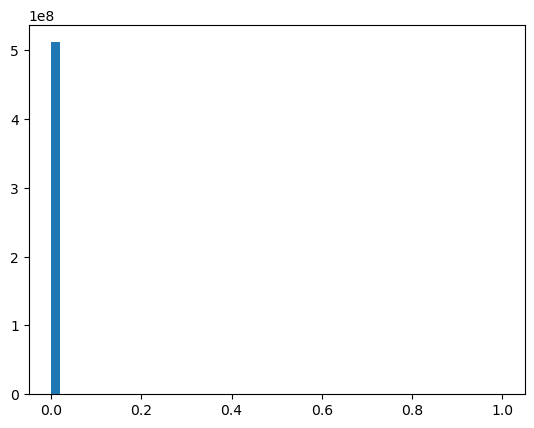

In [ ]:
hist, bins, _ = plt.hist(mut_infos, bins=50)
# plt.yscale('log')

**Applying log transform:**

In [ ]:
log_mut_infos = np.log(mut_infos + eps)

In [ ]:
np.isnan(log_mut_infos).sum(), np.isneginf(log_mut_infos).sum(), np.isinf(log_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(log_mut_infos)

CPU times: user 3.42 s, sys: 0 ns, total: 3.42 s
Wall time: 3.43 s


-1.3383214188674972

A little better skewness than before!

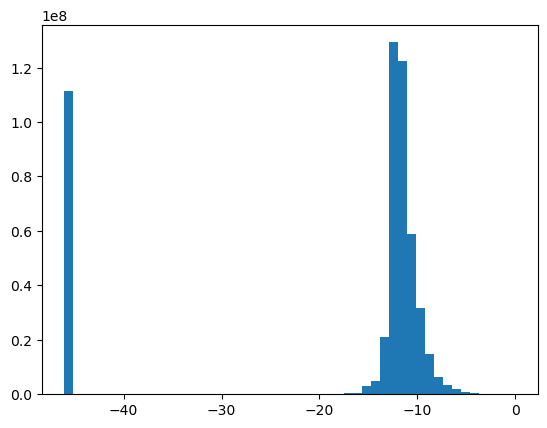

In [ ]:
hist, bins, _ = plt.hist(log_mut_infos, bins=50,)

**Applying sqrt transform:**

In [ ]:
sqrt_mut_infos = np.sqrt(mut_infos)

In [ ]:
np.isnan(sqrt_mut_infos).sum(), np.isinf(sqrt_mut_infos).sum(), np.isneginf(sqrt_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(sqrt_mut_infos)

CPU times: user 2.39 s, sys: 913 ms, total: 3.3 s
Wall time: 3.3 s


16.40865608826817

Worse than log transform!

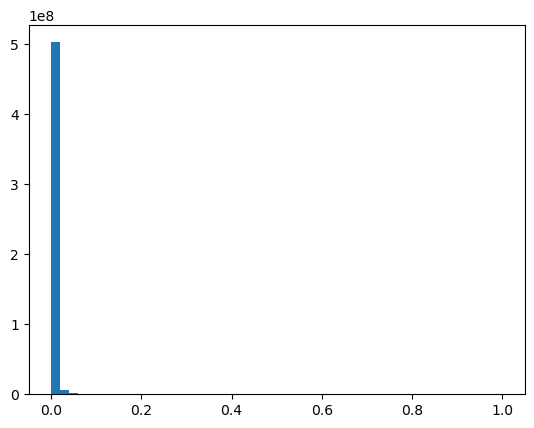

In [ ]:
hist, bins, _ = plt.hist(sqrt_mut_infos, bins=50)

**Apply box-cox transfrom:**

In [ ]:
bcx_mut_infos, *_ = boxcox(mut_infos+eps)

/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/scipy/stats/_morestats.py:933: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
np.isnan(bcx_mut_infos).sum(), np.isinf(bcx_mut_infos).sum(), np.isneginf(bcx_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(bcx_mut_infos)

CPU times: user 2.39 s, sys: 991 ms, total: 3.39 s
Wall time: 3.4 s


-0.885981418331696

This is the best skew so we'll go with boxcox.

In [ ]:
df_l2r['bcx_mutual_info'] = bcx_mut_infos

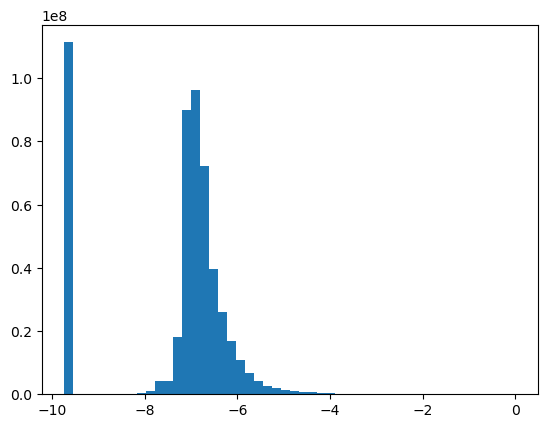

In [ ]:
hist, bins, _ = plt.hist(bcx_mut_infos, bins=50)

In [ ]:
np.min(bcx_mut_infos), np.max(bcx_mut_infos), np.mean(bcx_mut_infos), np.median(bcx_mut_infos)

(-9.734209, -3.6358892e-06, -7.381837, -6.9605794)

In [ ]:
# from IPython.display import clear_output

# clear_output(wait=True)

# from tqdm import tqdm
# from time import sleep
# import psutil

# with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
#     while True:
#         rambar.n=psutil.virtual_memory().percent
#         cpubar.n=psutil.cpu_percent()
#         rambar.refresh()
#         cpubar.refresh()
#         sleep(0.5)
#         clear_output(wait=True)

Box plots using matplotlib

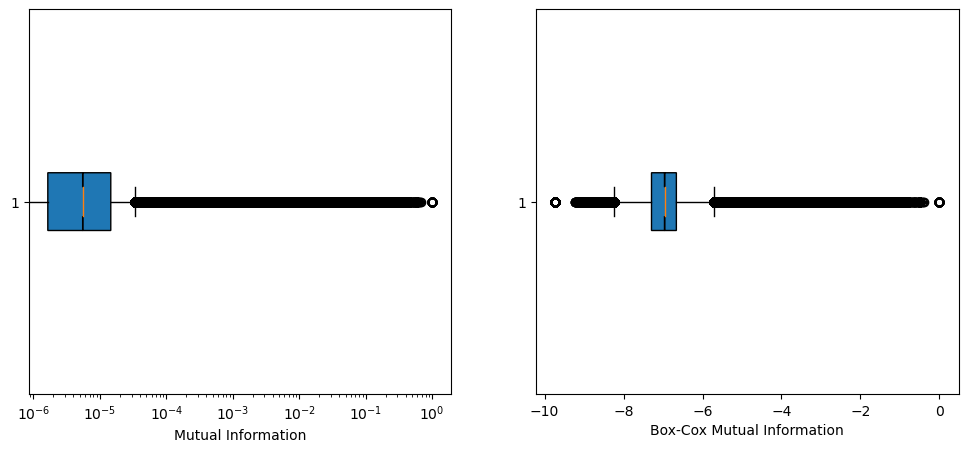

CPU times: user 1min 34s, sys: 2.57 s, total: 1min 36s
Wall time: 1min 36s


In [ ]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(mut_infos, vert=0, notch=True, patch_artist=True)
ax1.set_xscale('log')
ax1.set_xlabel('Mutual Information')

ax2.boxplot(bcx_mut_infos, vert=0, notch=True, patch_artist=True)
# ax2.set_xscale('symlog')
ax2.set_xlabel('Box-Cox Mutual Information')

plt.show()

Histograms and kde using matplotlib:

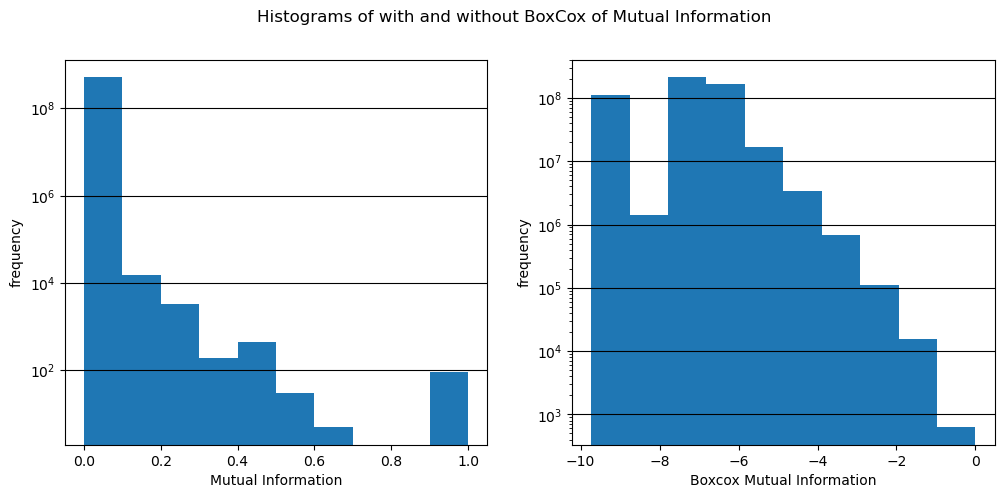

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# hist, bins, pathches = ax1.hist(df_l2r['mutual_info'])
hist, bins, pathches = ax1.hist(mut_infos)
ax1.set_xlabel('Mutual Information')
ax1.set_ylabel('frequency')
ax1.grid(axis='y', color='black')
ax1.set_yscale('log')

# ax2.hist(df_l2r['bcx_mutual_info'])
ax2.hist(bcx_mut_infos)
ax2.set_xlabel('Boxcox Mutual Information')
ax2.set_ylabel('frequency')
ax2.grid(axis='y', color='black')
ax2.set_yscale('log')

fig.suptitle('Histograms of with and without BoxCox of Mutual Information')
plt.show()

In [ ]:
bdrs = [bins[i:i+2] for i in range(0, len(bins)-1)]
pd.DataFrame({'mut_infos bdrs': bdrs, 'counts': hist})

,mut_infos bdrs,counts
0,"[0.0, 0.09999963641166687]",511675599.0
1,"[0.09999963641166687, 0.19999927282333374]",14848.0
2,"[0.19999927282333374, 0.2999989092350006]",3323.0
3,"[0.2999989092350006, 0.3999985456466675]",191.0
4,"[0.3999985456466675, 0.49999818205833435]",454.0
5,"[0.49999818205833435, 0.5999978184700012]",30.0
6,"[0.5999978184700012, 0.6999974250793457]",5.0
7,"[0.6999974250793457, 0.799997091293335]",0.0
8,"[0.799997091293335, 0.8999967575073242]",0.0
9,"[0.8999967575073242, 0.9999963641166687]",94.0


In [ ]:
# from scipy.stats import gaussian_kde
# density = gaussian_kde(df_l2r['mutual_info'])
# xs = np.linspace(0, 1, 200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs, density(xs))
# plt.show()

We can now build the `Dataloaders` object from this dataframe `df_collab`, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

## Build `L2RDataloader` 

In this section we'll build `L2RDataLoader` for [Learning to Rank (L2R)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)

In [ ]:
list_files(str(source))

mimic3_l2r/
    info.pkl
    code_descriptions.csv
    mimic3-9k_tok_lbl_info.pkl
    code_desc.pkl
    p_TL.pkl
    trn_val_split.pkl
    mimic3-9k_tok.ft
    mimic3-9k_lbl.ft
    mimic3-9k.csv
    scored_tokens.pth
    mimic3-9k_tok_lbl.ft


In [ ]:
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')
df_l2r = df_l2r.drop(['mutual_info', 'bcx_mutual_info'], axis=1)
df_l2r.token.nunique(), df_l2r.label.nunique()
df_l2r.head(3)

,token,label,rank
0,0,0,866.0
1,0,1,1022.0
2,0,2,1156.0


**`df_tiny`**: If we need a smaller dataset for quick iterations

Note: For technical reasons behind building a `L2RDataloader` the number of tokens should be $x (mod 64) \equiv 8$.

In [ ]:
num_toks, num_lbs = 8 + 5*64, 104

In [ ]:
# might have to repeat this a few times until the cell asserst true
np.random.seed(101)
rnd_toks = np.random.randint(0, len(df_l2r.token.unique()), size=(num_toks,) )
np.random.seed(101)
rnd_lbs = np.random.randint(0, len(df_l2r.label.unique()), size=(num_lbs,) )
mask = df_l2r.token.isin(rnd_toks) & df_l2r.label.isin(rnd_lbs)
df_tiny = df_l2r[mask].reset_index(drop=True)
test_eq(df_tiny.token.nunique(), num_toks) 
test_eq(df_tiny.label.nunique(), num_lbs) 
# df_tiny.apply(lambda x: x.nunique())

In [ ]:
df_tiny.head()

,token,label,rank
0,22,49,1877.0
1,22,239,21308.0
2,22,394,39854.0
3,22,436,8618.0
4,22,561,1646.0


Let's just delete the `df_l2r` to free up RAM:

In [ ]:
# df_l2r = pd.DataFrame()
# lst = [df_l2r]
# del lst
# del df_l2r
# import gc; gc.collect()

**Only for `df_tiny`**:

Due to random sampling the rankings are not uniform i.e., not from 0 to `num_toks`. A litte preprocessing to make sure that we have uniform rankings for all labels. 

In [ ]:
grouped = df_tiny.groupby('label', group_keys=False)

In [ ]:
def sort_rerank(df, column='rank'):
    df = df.sort_values(by=column)
    df['rank'] = range(len(df))
    return df

In [ ]:
df_tiny = grouped.apply(sort_rerank)
dict_grouped = dict(list(df_tiny.groupby('label')))
# checking a random label has ranks 0 thru `num_toks`
a_lbl = random.choice(list(dict_grouped.keys()))
test_eq(range(num_toks), dict_grouped[a_lbl]['rank'].values)

In [ ]:
dict_grouped[a_lbl].head()

,token,label,rank
3984,6376,2623,0
3360,5260,2623,1
1176,2265,2623,2
1072,2100,2623,3
1488,2998,2623,4


Using Pandas `groupby` to add quantized *relevance scores* to each token-label pair based on the corresponding ranks:

In [ ]:
grouped = df_tiny.groupby('label')

In [ ]:
# dict_grouped = dict(list(grouped))
# _tmp = dict_grouped[16].copy()
# _tmp.head()

In [ ]:
def cut(df, qnts, column='rank'):
    num = df.to_numpy()
    bins = np.quantile(num[:, -1], qnts)
    num[:, -1] = len(bins) - np.digitize(num[:, -1], bins)
    # bins = np.quantile(df['rank'], qnts)
    # df[column] = len(bins) - np.digitize(df['rank'], bins)
    # df[column] = pd.qcut(df[column], qnts, labels=labels)
    return num

In [ ]:
%%timeit -n 50 -r 15
qnts = np.concatenate([array([0]), np.geomspace(1e-2, 1, 10)])
scored = grouped.apply(cut, qnts) 

11.5 ms ± 248 µs per loop (mean ± std. dev. of 15 runs, 50 loops each)


Pandas `groupby` was just to ellucidate how we do the scoring. It ain't all that good when dealing with big datasets. So in reality we are going to use tensorized implemnetation. Follow along:

In [ ]:
pdl = PreLoadTrans(df_tiny, device=torch.device('cpu'))

If interested read  sourcecode of [`PreLoadTrans.quantized_score`](10_l2r.data.load):

In [ ]:
# %%timeit -n 50 -r 15
scored_toks = pdl.quantized_score()

In [ ]:
test_eqs(scored_toks.shape, 
         (df_tiny.label.nunique(), df_tiny.token.nunique(), 4), 
         (pdl.num_lbs, pdl.num_toks, 4))

Save if you want to! BTW `untar_xxx` has got the one for the full dataset:

In [ ]:
L(source.glob("**/*scored*.pth"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')]

Create training and validation split:

**Remember**: In `scored_toks` dim 0: labels, dim 1: 4 tuple (token, label, rank, score). Below is an example:

In [ ]:
tok, lbl, rank, score = L(scored_toks[97, 32], use_list=True).map(Tensor.item)
tok, lbl, rank, score

(41514.0, 8124.0, 234.0, 4.0)

In [ ]:
df_tiny[(df_tiny.token == tok)  & (df_tiny.label == lbl)]

,token,label,rank
23393,41514,8124,234


**Remember:** For each label the tokens are ranked 0 through `num_toks`

In [ ]:
ranks = scored_toks[:, :, 2].unique(dim=1).sort(-1)[0]
ranks_shouldbe = torch.arange(scored_toks.shape[1], dtype=torch.float).expand(scored_toks.shape[0], -1)
test_eq(ranks, ranks_shouldbe)

**Remember:** For each label `quantized_score` scores the tokens on a log scale based on their ranks. The score scale is 1-101: 101 being the highest score (assigned to most relevant  token), and 1 is the lowest score (assigned to least relevant tokens).

In [ ]:
scores = scored_toks[:, :, -1].unique(dim=1).sort(-1)[0]
scores[0]

tensor([  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   3.,
          3.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,   5.,   5.,   5.,   6.,
          6.,   6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,   8.,   8.,
          8.,   8.,   8.,   8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,   9.,
         10.,  10.,  10.,  10.,  11.,  11.,  11.,  11.,  11.,  11.,  12.,  12.,
         12.,  12.,  12.,  13.,  13.,  13.,  13.,  13.,  13.,  14.,  14.,  14.,
         14.,  15.,  15.,  15.,  16.,  16.,  16.,  17.,  17.,  17.,  17.,  17.,
         18.,  18.,  18.,  19.,  19.,  19.,  19.,  20.,  20.,  20.,  20.,  21.,
         21.,  21.,  21.,  22.,  22.,  22.,  22.,  23.,  23.,  23.,  23.,  24.,
         24.,  24.,  25.,  25.,  25.,  26.,  26.,  27.,  27.,  27.,  28.,  28.,
         29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,  34.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  42.,  43.,  45.,  48.,  51.,  55.,  63.,
        101.])

In [ ]:
%%time
scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds = pdl.train_val_split()

CPU times: user 222 ms, sys: 13.9 ms, total: 236 ms
Wall time: 34.9 ms


In [ ]:
%%time
val_sl = pdl.pad_split()
test_eq(is_valid.sum(dim=-1).unique().item(), val_sl)
print(f"{val_sl=}")

val_sl=16
CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 45.4 ms


Taking a look at the train/valid split for some labels (just to make sure we ticked all boxes!):

In [ ]:
df1 = pd.DataFrame(scored_toks[89], columns=['token', 'label', 'rank', 'score']).sort_values(by='score', ascending=False)
df1

,token,label,rank,score
226,28488.0,6820.0,0.0,101.0
225,2274.0,6820.0,1.0,63.0
224,50503.0,6820.0,2.0,55.0
223,56935.0,6820.0,3.0,51.0
222,20945.0,6820.0,4.0,48.0
...,...,...,...,...
112,57124.0,6820.0,320.0,1.0
114,9772.0,6820.0,318.0,1.0
115,907.0,6820.0,317.0,1.0
116,4924.0,6820.0,316.0,1.0


In [ ]:
name = partial(namestr, namespace=globals())
row_vals = apply(torch.Tensor.size, (scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds))
pd.DataFrame(index = list(itertools.chain.from_iterable(apply(name, [scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds]))), columns=['shape'], data={'shape': row_vals})

,shape
scored_toks,"(104, 328, 4)"
binned_toks,"(104, 328)"
probs,"(104, 328)"
is_valid,"(104, 328)"
bin_size,"(11,)"
bin_bds,"(8, 2)"


Lowest numbered bin contains irrelevant tokens for a label, and the highest numbered bin contains most relevant tokens:

In [ ]:
df2 = pd.DataFrame({'bin #': range(len(bin_size)), 
                    #'bin_bds': list(bin_bds.numpy()), 
                    'bin_size': bin_size})
df2

,bin #,bin_size
0,0,30
1,1,180
2,2,75
3,3,27
4,4,10
5,5,4
6,6,1
7,7,0
8,8,0
9,9,0


In [ ]:
df_toks = pd.read_feather(source/'mimic3-9k_tok.ft')
df_lbs = pd.read_feather(source/'mimic3-9k_lbl.ft')

a_lbl = np.random.choice(pdl.num_lbs)
df_lbs.iloc[[a_lbl]]
# df_lbs.loc[[a_lbl]]

,lbl,lbl_val
52,52,018.95


In [ ]:
df3 = pd.DataFrame({'token': scored_toks[a_lbl, :, 0] ,'score': scored_toks[a_lbl, :, -1], 'probs': probs[a_lbl], 
                    'binned_toks': binned_toks[a_lbl], 
                    #'bds': list(bin_bds[binned_toks[a_lbl]].numpy()), 
                    'size': bin_size[binned_toks[a_lbl]], 
                    'is_valid': is_valid[a_lbl]})
df3 = df_toks.merge(df3, on='token')
df3.sort_values(by='score', ascending=False).head(20)

,token,tok_val,score,probs,binned_toks,size,is_valid
30,4924,distance,101.0,0.333333,10,1,1.0
25,4056,defined,63.0,0.333333,6,1,0.0
10,2100,wnl,55.0,0.166667,5,4,0.0
2,436,change,51.0,0.166667,5,4,0.0
3,591,motion,48.0,0.166667,5,4,0.0
5,1327,residual,45.0,0.166667,5,4,0.0
0,22,patient,43.0,0.066667,4,10,0.0
7,1788,thursday,42.0,0.066667,4,10,0.0
6,1699,clopidogrel,40.0,0.066667,4,10,0.0
9,2021,saturations,39.0,0.066667,4,10,0.0


In [ ]:
test_eqs(is_valid[a_lbl].sum(), df3['is_valid'].sum(), pdl.val_sl)

In [ ]:
df3[df3['is_valid'] == 1].sort_values(by='score', ascending=False)#.groupby('binned_toks').size()

,token,tok_val,score,probs,binned_toks,size,is_valid
30,4924,distance,101.0,0.333333,10,1,1.0
12,2274,medial,35.0,0.066667,4,10,1.0
14,2998,synagis,34.0,0.066667,4,10,1.0
34,5700,50mcg,25.0,0.024691,3,27,1.0
22,3780,nephrostomy,23.0,0.024691,3,27,1.0
51,9331,lij,21.0,0.008889,2,75,1.0
201,38526,leveling,18.0,0.008889,2,75,1.0
55,9772,lid,15.0,0.008889,2,75,1.0
67,12108,ascities,11.0,0.003704,1,180,1.0
113,20957,thorocotomy,10.0,0.003704,1,180,1.0


In [ ]:
top_lens = pdl.count_topbins()
test_eq(top_lens.shape, [pdl.num_lbs])
print(f"For {torch.where(top_lens >= 1)[0].numel()} labels out of total {pdl.num_lbs}, in the validation set we have at least one top 2 bin")

For 50 labels out of total 104, in the validation set we have at least one top 2 bin


Prepare the train/val dataset:

In [ ]:
trn_dset, val_dset = pdl.datasets()

In [ ]:
test_eq(val_dset.shape, (scored_toks.shape[0], val_sl, scored_toks.shape[2]))
test_eq(trn_dset.shape, scored_toks.shape) 
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([104, 16, 4])


Again, `untar_xxx` has got the trn/val split for the full dataset:

In [ ]:
L(source.glob("**/*split*.pkl"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl')]

Now we are ready to create the train/valid `DataLoaders`:

**Implementation note:** We have written the training dataloader which we call `L2RDataLoader`. It ofcourse inherits from fastai's incredibly hackable [`DataLoader`](https://docs.fast.ai/data.load.html#dataloader) class. In a little more technical terms, another way to say this is that `L2RDataLoader` provides different implementation of the callbacks `before_iter` and `create_batches`. However for the validation dataloader we directly use fastai's `DataLoader`. Lastly, we store the training and validation dataloder objects using fastai's [`DataLoaders`](https://docs.fast.ai/data.core.html#dataloaders) class.

In [ ]:
val_dset = val_dset.unsqueeze(0)
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([1, 104, 16, 4])


In [ ]:
bs_full = 32
bs_tiny = 8
sl = 64
lbs_chunks_full = 4
lbs_chunks_tiny = 32
trn_dl = L2RDataLoader(dataset=trn_dset, sl=sl, bs=bs_tiny, lbs_chunks=lbs_chunks_tiny, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)

Don't forget to check the length

In [ ]:
len(trn_dl)

24

In [ ]:
ic(trn_dl.num_workers, trn_dl.fake_l.num_workers);

ic| trn_dl.num_workers: 1, trn_dl.fake_l.num_workers: 0


In [ ]:
xb = trn_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([8, 4, 64, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in progress_bar(trn_dl):
    time.sleep(0.01)

CPU times: user 2.95 s, sys: 8.9 ms, total: 2.96 s
Wall time: 1.79 s


In [ ]:
from fastai.data.load import DataLoader
from fastai.data.core import DataLoaders

In [ ]:
val_dset = val_dset.unsqueeze(0)
val_dl = DataLoader(val_dset, bs=1, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
ic(val_dl.num_workers, val_dl.fake_l.num_workers);

ic| val_dl.num_workers: 1, val_dl.fake_l.num_workers: 0


In [ ]:
xb = val_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([1, 104, 16, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in progress_bar(val_dl):
    time.sleep(0.01)

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.51 s


In [ ]:
dls = DataLoaders(trn_dl, val_dl)

## Training

...yes, finally!

#### **Keeping records:**

In [ ]:
m = ['lin', 'nn']
algos = ['ranknet', 'lambda-rank']
idx = pd.Index(['mimic-tiny', 'mimic-full'], name='dataset')
cols = pd.MultiIndex.from_product([m, algos], names = ['model', 'algo'])

In [ ]:
df = pd.DataFrame(columns=cols, index=idx)
df[:] = 'TBD'

In [ ]:
df.loc['mimic-tiny']['nn']['ranknet'] = {'lr': 1e-4, 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 70.67, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-tiny']['lin']['ranknet'] = {'lr': 1e-4, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 65.69, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-tiny']['nn']['lambda-rank'] = {'lr': [1e-2, 1e-3, 1e-4], 'opt': 'partial(Adam, mom=0.9, wd=0.4)', 'best': 62.75, 'epochs': [15, 15], 'seed': [1, str(8667)+' (L2RDataLoader)'], 'gain': 'exp', 'factors': 200}
df.loc['mimic-tiny']['lin']['lambda-rank'] = {'lr': [7e-3, 7e-4], 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 61.7, 'epochs': [15, 15], 'seed': 1, 'gain': 'exp', 'factors': 200}

df.loc['mimic-full']['nn']['ranknet'] = 'TBD'
df.loc['mimic-full']['lin']['ranknet'] = {'lr': 1e-5, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-full']['nn']['lambda-rank'] = 'TBD'
df.loc['mimic-full']['lin']['lambda-rank'] = {'lr': [7e-4, 7e-4, 7e-4], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}

In [ ]:
df

model                                                                                                                                   lin  \
algo                                                                                                                                ranknet   
dataset                                                                                                                                       
mimic-tiny  {'lr': 0.0001, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 65.69, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}   
mimic-full    {'lr': 1e-05, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}   

model                                                                                                                                                                      \
algo                                                                                                                                                          lambda-rank   
dataset                                                                                                                                                                     
mimic-tiny                    {'lr': [0.007, 0.0007], 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 61.7, 'epochs': [15, 15], 'seed': 1, 'gain': 'exp', 'factors': 200}   
mimic-full  {'lr': [0.0007, 0.0007, 0.0007], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}   

model                                                                                                                                        nn  \
algo                                                                                                                                    ranknet   
dataset                                                                                                                                           
mimic-tiny  {'lr': 0.0001, 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 70.67, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}   
mimic-full                                                                                                                                  TBD   

model                                                                                                                                                                                      
algo                                                                                                                                                                          lambda-rank  
dataset                                                                                                                                                                                    
mimic-tiny  {'lr': [0.01, 0.001, 0.0001], 'opt': 'partial(Adam, mom=0.9, wd=0.4)', 'best': 62.75, 'epochs': [15, 15], 'seed': [1, '8667 (L2RDataLoader)'], 'gain': 'exp', 'factors': 200}  
mimic-full                                                                                                                                                                            TBD

#### **Get the `DataLoaders`:**

In [ ]:
tmp = Path.cwd()/'tmp'
tmp.mkdir(exist_ok=True)
tmp.ls()

(#2) [Path('/home/deb/xcube/nbs/tmp/dls.pkl'),Path('/home/deb/xcube/nbs/tmp/ranknet-tiny.pth')]

In [ ]:
torch.manual_seed(1)
torch.initial_seed()

1

In [ ]:
# torch.save(dls, tmp/'dls.pkl', pickle_protocol=4)
dls = torch.load(tmp/'dls.pkl')

Based on the dataset:

In [ ]:
# num_lbs, num_toks, num_factors = 8922, 57352, 200
num_lbs, num_toks, num_factors = *dls.dataset.shape[:-1], 200
# num_lbs, num_toks, num_factors = pdl.num_lbs, pdl.num_toks, 100

In [ ]:
num_lbs, num_toks, num_factors

(104, 328, 200)

#### **Make the Model:**

In [ ]:
model = L2R_DotProductBias(num_lbs, num_toks, num_factors, y_range=None).cuda() #.to(default_device())
# model = L2R_NN(num_lbs, num_toks, num_factors, n_act=100, y_range=None).cuda() #.to(default_device())

**Create the `Learner` and train:**

In [ ]:
cbs = [TrainEval(), TrackResults(train_metrics=True), ProgressBarCallback(), Monitor(), SaveCallBack('lambdarank-tiny', monitor='ndcg_at_6')]

In [ ]:
from fastai.optimizer import *

In [ ]:
grad_fn = partial(rank_loss3, gain_fn='exp', k=6)
# learner = get_learner(model, dls, lr=1e-5) # lin # ranknet # full
# learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(RMSProp, mom=0.9, wd=0.0), lambrank=True, lr=7e-2) # lin # lambdarank # full
# learner = get_learner(model, dls, lr=1e-4, opt_func=partial(RMSProp, mom=0.9, wd=0.0)) 
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, lambrank=True, opt_func=partial(Adam, mom=0.9, wd=0.4))  # nn lambdarank tiny
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, lambrank=True, opt_func=partial(Adam, mom=0.9, wd=0.1))  # nn lambdarank full
# learner = get_learner(model, dls, lr=1e-4, cbs=cbs) #lin #ranknet #tiny
learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(SGD, mom=0.9, wd=0.0), lambrank=True, lr=7e-3, cbs=cbs) #lin #lambdarank #tiny

In [ ]:
learner.path = tmp

In [ ]:
getattrs(learner, 'grad_func', 'opt_func', 'opt', 'lr', 'loss_func')

[functools.partial(<function rank_loss3>, gain_fn='exp', k=6, lambrank=True),
 functools.partial(<function SGD>, mom=0.9, wd=0.0),
 None,
 0.007,
 <function xcube.l2r.gradients.loss_fn2(preds, xb, sigma=0.5)>]

In [ ]:
learner.fit(9)

0 True 1.5688 0.97 0.9534 0.5236
0 False 3.0235 0.4762 0.3297 0.5414
1 True 1.46 0.9783 0.9685 0.5309
1 False 3.043 0.4766 0.3334 0.5419
Better model found at epoch 1 with ndcg_at_6 value: 0.3334.
2 True 1.5932 0.9778 0.9643 0.5204
2 False 3.023 0.4789 0.3353 0.5425
Better model found at epoch 2 with ndcg_at_6 value: 0.3353.
3 True 1.2072 0.9774 0.9654 0.5616
3 False 2.995 0.4787 0.33 0.5432
4 True 1.1974 0.9806 0.9737 0.5679
4 False 2.9969 0.4784 0.3334 0.5429
5 True 1.2799 0.9829 0.9695 0.5579
5 False 2.9922 0.4785 0.3334 0.5418
6 True 1.1354 0.9843 0.9728 0.5718
6 False 2.9812 0.478 0.3362 0.5419
Better model found at epoch 6 with ndcg_at_6 value: 0.3362.
7 True 1.4326 0.9873 0.9813 0.5382
7 False 2.9837 0.4778 0.3362 0.542
8 True 1.3648 0.9391 0.8931 0.5376
8 False 2.8795 0.4817 0.3363 0.5487
Better model found at epoch 8 with ndcg_at_6 value: 0.3363.


In [ ]:
learner = learner.load('ranknet-tiny', device=default_device())

In [ ]:
learner.validate()

8 False 2.8795 0.4817 0.3363 0.5489


In [ ]:
learner.cbs[-1].best = 0.6512

In [ ]:
%%time
_ndcg_at_k = ndcg_at_k(to_device(learner.dls.dataset), learner.model, k=20)

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.5 s


In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 104])
    _ndcg_at_k.min(): tensor(1.8190e-12, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.9613, device='cuda:0')
    _ndcg_at_k.max(): tensor(1., device='cuda:0')
    _ndcg_at_k.median(): tensor(1., device='cuda:0')
    _ndcg_at_k.std(): tensor(0.1670, device='cuda:0')


In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 104])
    _ndcg_at_k.min(): tensor(3.5581e-08, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.8365, device='cuda:0')
    _ndcg_at_k.max(): tensor(1., device='cuda:0')
    _ndcg_at_k.median(): tensor(1., device='cuda:0')
    _ndcg_at_k.std(): tensor(0.3716, device='cuda:0')


---

In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 8922])
    _ndcg_at_k.min(): tensor(4.7923e-20, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.1285, device='cuda:0')
    _ndcg_at_k.max(): tensor(0.9074, device='cuda:0')
    _ndcg_at_k.median(): tensor(0.0614, device='cuda:0')
    _ndcg_at_k.std(): tensor(0.1649, device='cuda:0')


In [ ]:
a = accuracy(trn, model)

In [ ]:
a.mean(), a.std()

(tensor(0.5699, device='cuda:0'), tensor(0.0170, device='cuda:0'))

In [ ]:
x = trn.unsqueeze(0)

In [ ]:
y = learner.model(x)

In [ ]:
y.shape

torch.Size([1, 104, 328, 1])

In [ ]:
y, *_, test = ndcg(y, x, k=20)

In [ ]:
y.shape, test.shape

(torch.Size([1, 104, 328]), torch.Size([1, 104]))

In [ ]:
test.mean(), test.std()

(tensor(0.4002, device='cuda:0'), tensor(0.3429, device='cuda:0'))

In [ ]:
np.percentile(_ndcg_at_k.cpu().numpy(), 30)

0.22732760906219482

#### Plots

**Plotting losses and metrics:**

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
loss = L(loss_logger).map(torch.Tensor.item)
val_loss = L(metric_logger).itemgot(0)
val_acc = L(metric_logger).itemgot(-1)
val_ndcg = L(metric_logger).itemgot(2)

# axes[0,0].scatter(range(len(loss)), loss)
axes[0,0].plot(range(len(loss)), loss)
axes[0,0].set_xlabel('batches*epochs')
axes[0,0].set_ylabel('train loss')

axes[0,1].plot(val_loss)
axes[0,1].set_xlabel('epochs')
axes[0,1].set_ylabel('val loss')

axes[1, 0].plot(val_acc)
axes[1,0].set_xlabel('epochs')
axes[1,0].set_ylabel('val accuracy')

axes[1,1].plot(val_ndcg)
axes[1,1].set_xlabel('epochs')
axes[1,1].set_ylabel('val ndcg@6 (candidate 16)')

plt.show()

**Plotting Statistics of the Model Parameters**

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    mean_grads = L(v).map(compose(torch.Tensor.square, torch.Tensor.mean, torch.Tensor.sqrt, torch.Tensor.item))
    # sparsity = L(v).map(sparsity)
    ax.plot(mean_grads, color='r', label='mean')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('RMS of the Gradients of Model Parameters')
plt.show()

In [ ]:
def sparsity(t): 
    return 1 - (torch.count_nonzero(t)/t.numel()).item()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    sp = L(v).map(sparsity)
    ax.scatter(range(len(sp)), sp, color='r', label='sparsity')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('Sparsity of the Model Parameters')
plt.show()

#### Analysis to find out what the L2R model is upto:

**On the entire dataset:**

In [ ]:
def order_accuracy(dset):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    acc = []
    for chunk in  dset_chnked:
        btch_acc = batch_lbs_accuracy(rank_model(chunk), chunk)
        acc.append(btch_acc)
    acc = torch.cat(acc, dim=-1)
    return acc

In [ ]:
def ndcg_at_k(dset, k=20):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    ndcg_at_k_list = []
    for chunk in  dset_chnked:
        *_, ndcg_at_k = ndcg(rank_model(chunk), chunk, k=k)
        ndcg_at_k_list.append(ndcg_at_k)
    ndcg_at_k_all = torch.cat(ndcg_at_k_list, dim=-1)
    return ndcg_at_k_all

The `model` we are analysing:

In [ ]:
model = rank_model

In [ ]:
trn, _ = torch.load('trn_val_split.pkl')
trn = trn.to("cuda:0")
# trn_data = dls.train.dataset.to("cuda:0")
ic(trn.shape)

ic| trn.shape: torch.Size([8922, 57352, 3])


torch.Size([8922, 57352, 3])

In [ ]:
%%time
ndcg_at_20 = ndcg_at_k(trn, model, k=20)

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 12.8 s


In [ ]:
ic(ndcg_at_20.shape, ndcg_at_20.min(), ndcg_at_20.mean(), ndcg_at_20.max(), ndcg_at_20.median());

ic| ndcg_at_20.shape: torch.Size([1, 8922])
    ndcg_at_20.min(): tensor(1.1836e-26, device='cuda:0')
    ndcg_at_20.mean(): tensor(0.0003, device='cuda:0')
    ndcg_at_20.max(): tensor(0.2974, device='cuda:0')
    ndcg_at_20.median(): tensor(1.9523e-18, device='cuda:0')


In [ ]:
%%time
acc = accuracy(trn, model)

CPU times: user 1min 47s, sys: 602 ms, total: 1min 48s
Wall time: 13.9 s


In [ ]:
ic(acc.shape, acc.min(), acc.mean(), acc.max(), acc.median());

ic| acc.shape: torch.Size([1, 8922])
    acc.min(): tensor(0.9998, device='cuda:0')
    acc.mean(): tensor(1.0000, device='cuda:0')
    acc.max(): tensor(1., device='cuda:0')
    acc.median(): tensor(1., device='cuda:0')


(Below is ndcg formulation with just relevance on the numerator instead of 2 to the power of relevance)

In [ ]:
ic(ndcg_at_20.shape, ndcg_at_20.min(), ndcg_at_20.mean(), ndcg_at_20.max(), ndcg_at_20.median());

ic| ndcg_at_20.shape: torch.Size([1, 8922])
    ndcg_at_20.min(): tensor(0.0988, device='cuda:0')
    ndcg_at_20.mean(): tensor(0.4004, device='cuda:0')
    ndcg_at_20.max(): tensor(0.6808, device='cuda:0')
    ndcg_at_20.median(): tensor(0.4071, device='cuda:0')


In [ ]:
ndcg_at_20 = [None]
import gc; gc.collect(); torch.cuda.empty_cache()

In [ ]:
# ic(len(trn_data_chunked), trn_data.shape[1]/100, trn_data_chunked[-1].shape, trn_data.shape[1]%100)

On some selected labels:

In [ ]:
xb = trn[7000:7200]
xb = xb.unsqueeze(0)
ic(xb.shape);

ic| xb.shape: torch.Size([1, 200, 57352, 3])


In [ ]:
%%time
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(model(xb), xb, k=20)

CPU times: user 699 ms, sys: 10.7 ms, total: 709 ms
Wall time: 1.24 s


In [ ]:
_ndcg_at_k.mean()

tensor(5.6429e-07, device='cuda:0')

---

**On a training batch:**

In [ ]:
xb_iter = iter(dls.train)

In [ ]:
xb = next(xb_iter)

In [ ]:
preds = rank_model(xb)
ic(xb.shape, xb.device, preds.shape, preds.device);

ic| xb.shape: torch.Size([64, 2233, 64, 4])
    xb.device: device(type='cuda', index=0)
    preds.shape: torch.Size([64, 2233, 64, 1])
    preds.device: device(type='cuda', index=0)


In [ ]:
%%time
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(model(xb), xb, k=10)

CPU times: user 1.41 s, sys: 3.31 ms, total: 1.42 s
Wall time: 3.33 s


In [ ]:
ic(_ndcg.shape, _ndcg.mean(), _ndcg_at_k.shape, _ndcg_at_k.mean());

ic| _ndcg.shape: torch.Size([64, 2233])
    _ndcg.mean(): tensor(0.7898, device='cuda:0')
    _ndcg_at_k.shape: torch.Size([64, 2233])
    _ndcg_at_k.mean(): tensor(0.2059, device='cuda:0')


Let's compute order accuracy:

In [ ]:
btch_acc = accuracy(xb, rank_model)
ic(btch_acc.shape, btch_acc.mean());

ic| btch_acc.shape: torch.Size([64, 2233])
    btch_acc.mean(): tensor(0.6112, device='cuda:0', grad_fn=<MeanBackward0>)


**On a validation batch:**

In [ ]:
xb_val = dls.valid.one_batch()
ic(xb_val.shape, xb_val.device);

ic| xb_val.shape: torch.Size([1, 8922, 32, 4])
    xb_val.device: device(type='cuda', index=0)


In [ ]:
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(rank_model(xb_val), xb_val, k=5)

In [ ]:
ic(_ndcg.shape, _ndcg.mean(), _ndcg_at_k.shape, _ndcg_at_k.mean());

ic| _ndcg.shape: torch.Size([1, 8922])
    _ndcg.mean(): tensor(0.7097, device='cuda:0')
    _ndcg_at_k.shape: torch.Size([1, 8922])
    _ndcg_at_k.mean(): tensor(0.1040, device='cuda:0')


In [ ]:
xb = xb_val

Let's compute order accuracy:

In [ ]:
acc = accuracy(xb, rank_model)
ic(acc.shape, acc.mean());

ic| acc.shape: torch.Size([1, 8922])
    acc.mean(): tensor(0.5952, device='cuda:0')


**Let's pick a label and see the rankings produced by the model:**

In [ ]:
lbl = 7056

In [ ]:
xb.shape

torch.Size([1, 200, 57352, 3])

In [ ]:
xb[0, lbl%100, :, 1].unique()

tensor([7056.], device='cuda:0')

In [ ]:
ic(dcg[0, lbl%100], idcg[0, lbl%100], _ndcg[0, lbl%100]);

ic| dcg[0, lbl%100]: tensor(49457.4609, device='cuda:0')
    idcg[0, lbl%100]: tensor(51637.4922, device='cuda:0')
    _ndcg[0, lbl%100]: tensor(0.9578, device='cuda:0')


In [ ]:
_ndcg_at_k[0, lbl%100]

tensor(2.8407e-16, device='cuda:0')

In [ ]:
eps = 1e-15
_data = torch.concat(
            (xb[0, lbl%100], preds[0, lbl%100].unsqueeze(-1), preds_rank[0, lbl%100].unsqueeze(-1), ideal_rank[0, lbl%100].unsqueeze(-1), discnt_fac[0, lbl%100].unsqueeze(-1), ideal_discnt_fac[0, lbl%100].unsqueeze(-1), discntd_gain[0, lbl%100].unsqueeze(-1), ideal_discntd_gain[0, lbl%100].unsqueeze(-1)
        ), dim=-1)
_df = pd.DataFrame(_data, 
             columns=['tok', 'lbl', 'score', 'preds', 'model_rank', 'ideal_rank', 'model_discount factor', 'ideal_discount_factor', 'discounted gain', 'ideal discounted gain'])#.sort_values(by='score', ascending=False)
ic(len(_df));
random_rank = torch.randperm(len(_df))
_df['random_rank'] = random_rank
random_discnt_fac = torch.log2(2 + random_rank)
_df['random_discount_factor'] = random_discnt_fac

_df['discounted gain'] = (np.power(2, _df['score']) - 1) / (_df['model_discount factor'] + eps)
_df['ideal discounted gain'] = (np.power(2, _df['score']) - 1) / (_df['ideal discounted gain'] + eps)
_df['random_discnt_gain'] = (np.power(2, _df['score']) - 1) / (_df['random_discount_factor'] + eps)

_df.head()

ic| len(_df): 57352


,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
0,0.0,7056.0,52.0,0.0,0.0,455.0,1.000000,8.836050,4.503600e+15,7.652698e+14,53131,15.697321,2.869024e+14
1,1.0,7056.0,4.0,0.0,1.0,39530.0,1.584962,15.270733,9.463946e+00,5.726525e+01,19867,14.278232,1.050550e+00
2,2.0,7056.0,4.0,0.0,2.0,39531.0,2.000000,15.270770,7.500000e+00,5.726539e+01,38645,15.238069,9.843767e-01
3,3.0,7056.0,4.0,0.0,3.0,39532.0,2.321928,15.270806,6.460148e+00,5.726552e+01,2377,11.216140,1.337358e+00
4,4.0,7056.0,4.0,0.0,4.0,39533.0,2.584962,15.270843,5.802793e+00,5.726566e+01,24434,14.576720,1.029038e+00


In [ ]:
_df1 = _df.sort_values(by='preds', ascending=False).head(20)
_df1.head(10)

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
0,0.0,7056.0,52.0,0.0,0.0,455.0,1.000000,8.836050,4.503600e+15,7.652698e+14,53131,15.697321,2.869024e+14
39429,39429.0,7056.0,7.0,0.0,39429.0,29941.0,15.267043,14.869931,8.318572e+00,2.697831e+02,17258,14.075145,9.022998e+00
38227,38227.0,7056.0,10.0,0.0,38227.0,24383.0,15.222380,14.573707,6.720368e+01,1.490890e+03,45839,15.484351,6.606670e+01
38228,38228.0,7056.0,2.0,0.0,38228.0,49027.0,15.222418,15.581347,1.970778e-01,2.337202e+01,21011,14.358994,2.089283e-01
38229,38229.0,7056.0,2.0,0.0,38229.0,49028.0,15.222455,15.581377,1.970773e-01,2.337206e+01,47460,15.534485,1.931187e-01
38230,38230.0,7056.0,9.0,0.0,38230.0,26157.0,15.222493,14.675020,3.356874e+01,8.332151e+02,26441,14.690598,3.478415e+01
38231,38231.0,7056.0,8.0,0.0,38231.0,28058.0,15.222530,14.776227,1.675149e+01,4.709922e+02,50023,15.610362,1.633530e+01
38232,38232.0,7056.0,9.0,0.0,38232.0,26158.0,15.222569,14.675075,3.356858e+01,8.332181e+02,25692,14.649144,3.488258e+01
38233,38233.0,7056.0,10.0,0.0,38233.0,24384.0,15.222607,14.573766,6.720268e+01,1.490896e+03,42174,15.364135,6.658364e+01
38234,38234.0,7056.0,9.0,0.0,38234.0,26159.0,15.222644,14.675130,3.356841e+01,8.332213e+02,23758,14.536247,3.515350e+01


In [ ]:
lbl_dcg20 = ( (pow(2, _df1.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_dcg20

5481220478165346.0

In [ ]:
# lbl_dcg20 = _df1['discounted gain'].sum()
# lbl_dcg20

In [ ]:
_df2 = _df.sort_values(by='score', ascending=False).head(20)
_df2.head(10)

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
41633,41633.0,7056.0,101.0,2.175395,21063.0,0.0,14.362560,1.000000,1.765215e+29,2.510199e+28,46470,15.504074,1.635248e+29
46021,46021.0,7056.0,100.0,-0.183124,25097.0,5.0,14.615342,2.807355,8.673424e+28,3.558745e+28,27876,14.766839,8.584442e+28
22263,22263.0,7056.0,100.0,-1.027545,26530.0,4.0,14.695446,2.584962,8.626146e+28,3.276829e+28,37411,15.191252,8.344610e+28
18628,18628.0,7056.0,100.0,32.953648,1527.0,1.0,10.578373,1.584962,1.198342e+29,2.009179e+28,6920,12.756973,9.936923e+28
18638,18638.0,7056.0,100.0,1.686037,21875.0,2.0,14.417128,2.000000,8.792671e+28,2.535301e+28,52030,15.667111,8.091157e+28
20038,20038.0,7056.0,100.0,-13.829051,46904.0,3.0,15.517485,2.321928,8.169175e+28,2.943393e+28,41464,15.339642,8.263886e+28
17155,17155.0,7056.0,99.0,-12.660876,45510.0,6.0,15.473959,3.000000,4.096077e+28,1.920683e+28,25385,14.631803,4.331833e+28
14456,14456.0,7056.0,97.0,-23.737192,54115.0,7.0,15.723794,3.169925,1.007749e+28,5.178296e+27,55496,15.760148,1.005424e+28
14135,14135.0,7056.0,96.0,4.254682,17779.0,8.0,14.118049,3.321928,5.611835e+27,2.741565e+27,53704,15.712795,5.042270e+27
16272,16272.0,7056.0,95.0,33.406235,1496.0,9.0,10.548821,3.459432,3.755309e+27,1.442550e+27,39661,15.275506,2.593307e+27


In [ ]:
lbl_idcg20 = ( (pow(2, _df2.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_idcg20

5.762852934816773e+30

In [ ]:
# lbl_idcg20 = _df2['ideal discounted gain'].sum()
# lbl_idcg20

In [ ]:
# lbl_ndcg20 = lbl_dcg20/lbl_idcg20
# lbl_ndcg20

In [ ]:
lbl_ndcg20 = lbl_dcg20 /lbl_idcg20
lbl_ndcg20

9.511296818022338e-16

In [ ]:
np.isclose(lbl_ndcg20, _ndcg_at_k[0, lbl%100].item())

True

In [ ]:
_df3 = _df.sort_values(by='random_rank', ascending=True).head(20)
_df3

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
6452,6452.0,7056.0,5.0,-8.187328,38783.0,36091.0,15.243211,15.139431,2.033692e+00,9.386447e+01,0,1.000000,3.100000e+01
16794,16794.0,7056.0,22.0,-7.473664,37611.0,7553.0,15.198944,12.883216,2.759602e+05,2.456187e+06,1,1.584962,2.646310e+06
35009,35009.0,7056.0,8.0,-11.835570,44385.0,27803.0,15.437850,14.763057,1.651784e+01,4.705724e+02,2,2.000000,1.275000e+02
57162,57162.0,7056.0,5.0,3.476361,19059.0,39396.0,14.218336,15.265835,2.180283e+00,9.464817e+01,3,2.321928,1.335097e+01
47032,47032.0,7056.0,6.0,-19.453012,51849.0,35224.0,15.662085,15.104353,4.022453e+00,1.585957e+02,4,2.584963,2.437173e+01
39202,39202.0,7056.0,9.0,3.024749,19741.0,26507.0,14.269053,14.694195,3.581177e+01,8.343037e+02,5,2.807355,1.820219e+02
55155,55155.0,7056.0,1.0,-7.111054,37005.0,56015.0,15.175510,15.773577,6.589564e-02,1.577358e+01,6,3.000000,3.333333e-01
15844,15844.0,7056.0,3.0,-7.391142,37482.0,43443.0,15.193987,15.406902,4.607086e-01,3.594944e+01,7,3.169925,2.208254e+00
35714,35714.0,7056.0,10.0,-2.225584,28616.0,23093.0,14.804635,14.495293,6.909998e+01,1.482869e+03,8,3.321928,3.079537e+02
20591,20591.0,7056.0,3.0,-16.564301,49692.0,44555.0,15.600784,15.443364,4.486954e-01,3.603452e+01,9,3.459432,2.023454e+00


In [ ]:
lbl_rnd_dcg20 = ( (pow(2, _df3.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_rnd_dcg20

6747168816.981719

In [ ]:
# lbl_rnd_dcg20 = _df3['random_discnt_gain'].sum()
# lbl_rnd_dcg20

In [ ]:
lbl_rnd_ndcg20 = lbl_rnd_dcg20/lbl_idcg20
lbl_rnd_ndcg20

1.1708035747742436e-21

---

#### Looking at the token ranks for each label

##### Setting things up ... for analysis later!

In [ ]:
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)
df_toks = pd.read_feather(collab_tok_path)
df_lbs = pd.read_feather(collab_lbl_path)
df_lbs['description'] = df_lbs['lbl_val'].map(lambda x: lbs_desc.get(x, "Not Found"))
# df_collab = pd.read_feather(collab_data_path)

In [ ]:
df_collab = pd.DataFrame()
lst = [df_collab]
del lst
del df_collab
import gc; gc.collect()

73

In [ ]:
# df_toks.head()

In [ ]:
# df_lbs.head()

In [ ]:
df_toks_tiny = df_toks.iloc[:num]
df_lbs_tiny = df_lbs.iloc[:num]

In [ ]:
# lbs_list = random.sample(list(df_lbs.lbl_val), k=10)
# df_lbs[df_lbs.lbl_val.isin(lbs_list)]

In [ ]:
# df_collab.head(3)

In [ ]:
from datetime import datetime
ic(datetime.fromtimestamp(time.time()))
ic(datetime.fromtimestamp(collab_path.stat().st_ctime));

ic| datetime.fromtimestamp(time.time()): datetime.datetime(2022, 7, 30, 16, 33, 23, 596222)
ic| datetime.fromtimestamp(collab_path.stat().st_ctime): datetime.datetime(2022, 7, 28, 7, 31, 24, 743458)


In [ ]:
dls_collab = torch.load(dls_collab_path)

In [ ]:
dls_collab.classes['token'].map_objs([9, 17]), dls_collab.classes['token'].map_ids([1,8])

In [ ]:
collab_dict = load_learner(collab_path, cpu=False)
if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
test_eq(type(collab_dict), OrderedDict)
test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])

In [ ]:
for key in collab_dict.keys():
    ic(key, collab_dict[key].shape)

ic| key: 'token_factors.weight'
    collab_dict[key].shape: torch.Size([57352, 400])
ic| key: 'token_bias.weight'
    collab_dict[key].shape: torch.Size([57352, 1])
ic| key: 'label_factors.weight'
    collab_dict[key].shape: torch.Size([8922, 400])
ic| key: 'label_bias.weight'
    collab_dict[key].shape: torch.Size([8922, 1])


In [ ]:
toks_red = df_toks.token.to_numpy() #dls_collab.classes['token']
lbs = df_lbs.lbl.to_numpy() #dls_collab.classes['label']

In [ ]:
n_factors = 400
# 0 is a nan added by collab dataloaders
tok_wgts = collab_dict['u_weight.weight'].detach(); test_eq(tok_wgts.shape, (len(toks_red), n_factors))
lbs_wgts = collab_dict['i_weight.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
tok_bias = collab_dict['u_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks_red), 1])
lbs_bias = collab_dict['i_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])

In [ ]:
a_lbl_list = ['038.2', '038.19']

In [ ]:
df_lbs[df_lbs.lbl_val.isin(a_lbl_list)]

,lbl,lbl_val,description
78,78,038.19,Other staphylococcal septicemia
79,79,038.2,Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_list = df_lbs.loc[df_lbs.lbl_val.isin(a_lbl_list)].lbl.to_numpy()
# lbl_list = df_lbs[df_lbs.lbl_val.isin(a_lbl_list)].index
ic(lbl_list);

ic| lbl_list: array([78, 79])


In [ ]:
ic(df_lbs.iloc[lbl_list]);

ic| df_lbs.iloc[lbl_list]:     lbl lbl_val                                                    description
                           78   78  038.19                                Other staphylococcal septicemia
                           79   79   038.2  Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_idxs = lbs.map_objs(lbl_list)
ic(lbl_idxs);

ic| lbl_idxs: [79, 80]


In [ ]:
ic(lbs_wgts.shape);

ic| lbs_wgts.shape: torch.Size([8923, 400])


In [ ]:
sclt_lbl_wgts = lbs_wgts[lbl_idxs]
ic(sclt_lbl_wgts.shape);

ic| sclt_lbl_wgts.shape: torch.Size([2, 400])


In [ ]:
sclt_lbl_bias = lbs_bias[lbl_idxs]
ic(sclt_lbl_bias.shape);

ic| sclt_lbl_bias.shape: torch.Size([2, 1])


In [ ]:
ic(tok_wgts.shape)
ic(tok_bias.shape);

ic| tok_wgts.shape: torch.Size([33648, 400])
ic| tok_bias.shape: torch.Size([33648, 1])


In [ ]:
lbl_all_toks = (tok_wgts[1:] @ sclt_lbl_wgts.T) + tok_bias[1:] + sclt_lbl_bias.T 
lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1)
ic(lbl_all_toks.shape);
# ic('#######')
# lbl_all_toks_full = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T 
# lbl_all_toks_full = sigmoid_range(lbl_all_toks_full, low=0, high=1)
# ic(lbl_all_toks_full.shape);

ic| lbl_all_toks.shape: torch.Size([33647, 2])


In [ ]:
sorted_tok_idxs = torch.argsort(lbl_all_toks, dim=0, descending=True)
ic(sorted_tok_idxs)
ic(sorted_tok_idxs.shape);
# ic('########')
# sorted_tok_idxs_full = torch.argsort(lbl_all_toks_full, dim=0, descending=True)
# ic(sorted_tok_idxs_full)
# ic(sorted_tok_idxs_full.shape);

ic| sorted_tok_idxs: tensor([[17573, 17573],
                             [33311, 27710],
                             [31448, 33311],
                             ...,
                             [  383,  7374],
                             [ 7731,  7731],
                             [  313, 10875]], device='cuda:0')
ic| sorted_tok_idxs.shape: torch.Size([33647, 2])


In [ ]:
import copy
toks_red_array = L(copy.deepcopy(toks_red))
toks_red_array.remove('#na#')
toks_red_array = tensor(toks_red_array)

In [ ]:
toks_all = df_toks.tok_val.to_numpy(dtype=np.str_)
ic(toks_all);

ic| toks_all: array(['xxunk', 'xxpad', 'xxbos', ..., 'pipelle', 'xxfake', 'xxfake'], dtype='<U29')


In [ ]:
# %%timeit
toks_array = toks_all[toks_red_array[sorted_tok_idxs]]
ic(toks_array.shape);

ic| toks_array.shape: (33647, 2)


In [ ]:
# %%timeit
# toks_array_0 = toks_all[toks_red_array[sorted_tok_idxs[:,0]]]
# toks_array_1 = toks_all[toks_red_array[sorted_tok_idxs[:,1]]]

In [ ]:
# %%timeit
# toks_0 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,0]]].tok_val.to_numpy(dtype=np.str_)
# toks_1 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,1]]].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# %%timeit
# toks_0_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,0]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)
# toks_1_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,1]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# torch.logical_not(tensor(toks_0 == toks_0_full)).sum()

In [ ]:
def lbs_sorted_tokens(df_toks, df_lbs, collab_path, dls_collab_path=None, lbl_list=None):
    # import pdb; pdb.set_trace()
    collab_dict = load_learner(collab_path, cpu=False)
    if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
    test_eq(type(collab_dict), OrderedDict)
    test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])
    
    toks = df_toks.token.to_numpy() # dls_collab.classes['token'] # not needed
    toks_arr = to_device(tensor(toks))
    lbs = df_lbs.lbl.to_numpy() # dls_collab.classes['label'] # not needed
    
    n_factors = collab_dict['token_factors.weight'].shape[1]
    tok_wgts = collab_dict['token_factors.weight'].detach(); test_eq(tok_wgts.shape, (len(toks), n_factors))
    lbs_wgts = collab_dict['label_factors.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
    tok_bias = collab_dict['token_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks), 1])
    lbs_bias = collab_dict['label_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])
    
    lbl_idxs = df_lbs.loc[df_lbs.lbl_val.isin(lbl_list)].lbl.to_numpy() if lbl_list is not None else df_lbs.lbl.to_numpy()
    sclt_lbl_wgts = lbs_wgts[lbl_idxs]
    sclt_lbl_bias = lbs_bias[lbl_idxs]
    lbl_all_toks = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T # there is no nan
    test_eq(lbl_all_toks.shape, (len(toks), len(lbs)))
    # lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1) # not needed
    sorted_tok_vals, sorted_tok_idxs = torch.sort(lbl_all_toks, dim=0, descending=True)
    sorted_tok_vals, sorted_tok_idxs = sorted_tok_vals.cpu(), sorted_tok_idxs.cpu()
    torch.cuda.empty_cache()
    # sorted_toks = toks_arr[sorted_tok_idxs].cpu() # no longer needed
    # test_eq(sorted_toks, sorted_tok_idxs.cpu())
    # toks_names = df_toks.tok_val.to_numpy(dtype=np.str_)
    # sorted_tok_names= toks_names[sorted_toks]
    return sorted_tok_vals, sorted_tok_idxs #, sorted_tok_names 

In [ ]:
lbs_list = None
lbs_idxs = df_lbs_tiny.loc[df_lbs_tiny.lbl_val.isin(lbs_list)].lbl.to_numpy() if lbs_list is not None else df_lbs_tiny.lbl.to_numpy()

In [ ]:
%%time
sorted_tok_vals, sorted_tok_idxs = lbs_sorted_tokens(df_toks_tiny, df_lbs_tiny, collab_path_tiny, lbl_list=lbs_list)

CPU times: user 985 ms, sys: 182 ms, total: 1.17 s
Wall time: 2.38 s


In [ ]:
%%timeit
with open('sorted_toks.pt', 'wb') as f: pickle.dump(sorted_toks, f, pickle.HIGHEST_PROTOCOL)

The slowest run took 7.77 times longer than the fastest. This could mean that an intermediate result is being cached.
13.9 s ± 11.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
torch.save((sorted_tok_vals, sorted_tok_idxs), 'sorted_toks.pt');

CPU times: user 1.58 s, sys: 15.3 s, total: 16.9 s
Wall time: 17.7 s


In [ ]:
cols = np.arange(sorted_tok_idxs.shape[0]).astype(np.str)
df_cf = pd.DataFrame(sorted_tok_idxs.T, index=range(sorted_tok_idxs.shape[1]), columns=cols, dtype=np.int32)
df_cf['lbl'] = lbs_idxs
cols = list(df_cf.columns)
cols =  [cols[-1]] + cols[:-1]
df_cf = df_cf[cols]
df_cf = pd.merge(df_lbs, df_cf, on='lbl')
ic(df_cf.memory_usage().sum()/1024**3);
df_cf.to_feather('mut_info_cf.ft')

ic| df_cf.memory_usage().sum()/1024**3: 1.906476616859436


##### Loading things up.. for analysis now!

In [ ]:
df_cf = pd.read_feather('mut_info_cf.ft')

In [ ]:
sorted_tok_vals, sorted_tok_idxs = torch.load('sorted_toks.pt')

In [ ]:
toks_names = df_toks_tiny.tok_val.to_numpy(dtype=np.str_)
lbl_names = df_lbs_tiny.lbl_val.to_numpy(dtype=np.str_)

In [ ]:
tid = np.where(toks_names == 'quetiapine')[0].item()
lid = np.where(lbl_names == '157.3')[0].item()
ic(tid, lid);

ic| tid: 3374, lid: 434


In [ ]:
mask = (df_collab.token == tid) & (df_collab.label == lid)

In [ ]:
# df_collab.head(5)
# df_collab.pivot(index='token', columns='label', values='rank') 

In [ ]:
collab_bootstrap = torch.load(collab_bootst_path)
ic(collab_bootstrap.keys());
info = collab_bootstrap.get('mutual_info_jaccard', None)
assert info is not None
info = torch.tensor(info)

ic| collab_bootstrap.keys(): dict_keys(['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])


Removing negs before boxcox:

In [ ]:
ic(torch.sum(info<0));
eps = torch.ones(1).new_empty(1).fill_(1e-20).item()
info[info<0] = eps
test_eq(torch.sum(info<0), 0)

ic| torch.sum(info<0): tensor(111226814, device='cuda:0')


In [ ]:
%%time
bcx_info, *_ = boxcox(info.cpu().flatten() + eps)
bcx_info = bcx_info.reshape(info.shape[0], info.shape[1])

CPU times: user 3min 19s, sys: 22.9 s, total: 3min 42s
Wall time: 3min 39s


In [ ]:
torch.save(bcx_info, 'bcx_info.pkl')

Rank the bcx_info in the GPU, then move it to CPU and free up the GPU:

In [ ]:
bcx_info = torch.load('bcx_info.pkl')
test_eq(type(bcx_info), ndarray)

**Use the following cell only for the tiny dataset:**

In [ ]:
bcx_info = bcx_info[:num, :num]
ic(bcx_info.shape);

ic| bcx_info.shape: (100, 100)


In [ ]:
bcx_info = torch.as_tensor(bcx_info, device=default_device())

In [ ]:
%%time
rnk_info = torch.argsort(bcx_info, dim=0, descending=True).argsort(dim=0)
rnk_info = to_device(rnk_info, device=torch.device("cpu"))
rnk_info = rnk_info.numpy()
torch.cuda.empty_cache()

CPU times: user 2.14 ms, sys: 423 µs, total: 2.56 ms
Wall time: 33 ms


In [ ]:
ic(rnk_info.shape); # these are the ranks of all the tokens for the corresponding labels
# rnk_info_df = pd.DataFrame(rnk_info)
# rnk_info_df.columns.name = 'labels'
# rnk_info_df.index.name = 'tokens'
# rnk_info_df.head()

ic| rnk_info.shape: (100, 100)


In [ ]:
%%time
sorted_toks_orig_ranks = np.empty_like(sorted_tok_idxs)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_orig_ranks[:, lbl] = rnk_info[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 4.84 ms, sys: 0 ns, total: 4.84 ms
Wall time: 3.23 ms


In [ ]:
%%time
bcx_info_cpu = bcx_info.cpu().numpy()
sorted_toks_bcx_info = np.empty_like(sorted_tok_idxs, dtype=np.float)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_bcx_info[:, lbl] = bcx_info_cpu[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 2.46 ms, sys: 461 µs, total: 2.92 ms
Wall time: 2.58 ms


In [ ]:
sorted_toks = np.stack((sorted_tok_idxs, sorted_toks_bcx_info, sorted_toks_orig_ranks, sorted_tok_vals), axis=-1)
test_eq(sorted_toks.shape, (*sorted_tok_idxs.shape, 4))

In [ ]:
columns = pd.MultiIndex.from_product([range(sorted_toks.shape[1]), ('idx', 'info', 'act_rank', 'pred')], names=['label', 'key2'])

In [ ]:
_df = pd.DataFrame(sorted_toks.reshape(sorted_toks.shape[0], sorted_toks.shape[1]*4), 
                                  index=range(sorted_toks.shape[0]), columns=columns)
_df.index.name = 'tokens'
# pd.set_option('display.max_rows',None)
_df

label     0                                  1                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       99.0 -6.209785      0.0 -6.206440  92.0 -6.378193      1.0 -6.409137   
1       97.0 -6.219368      1.0 -6.242119  94.0 -6.454948      2.0 -6.457011   
2       61.0 -6.240334      2.0 -6.246603  24.0 -6.662710     10.0 -6.541097   
3       39.0 -6.625558     39.0 -6.251883  96.0 -6.549222      3.0 -6.554122   
4       96.0 -6.310939      3.0 -6.314555  29.0 -6.586070      4.0 -6.578732   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95      12.0 -9.734209     97.0 -9.736045   4.0 -9.734209     95.0 -9.736048   
96       8.0 -9.734209     99.0 -9.739898  11.0 -9.727593     91.0 -9.736523   
97       7.0 -9.734209     94.0 -9.741494  51.0 -9.734209     96.0 -9.737504   
98       1.0 -9.734209     93.0 -9.744768  17.0 -9.727593     88.0 -9.739672   
99       4.0 -9.734209     95.0 -9.746672   3.0 -9.734209     98.0 -9.741522   

label     2                                  3                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       76.0 -6.588891     32.0 -6.129146  44.0 -6.182239      0.0 -6.207527   
1       46.0 -6.230028      0.0 -6.223404  75.0 -6.275874      1.0 -6.293755   
2       21.0 -6.480742     10.0 -6.307346  35.0 -6.331505      3.0 -6.365513   
3       42.0 -6.309279      1.0 -6.312391  99.0 -6.455512      4.0 -6.456026   
4       96.0 -6.310939      2.0 -6.320697  97.0 -6.464425      5.0 -6.485068   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       8.0 -9.734209     99.0 -9.732467   3.0 -9.734209     98.0 -9.739051   
96       2.0 -9.734209     92.0 -9.736560  12.0 -9.734209     97.0 -9.739160   
97       1.0 -9.734209     93.0 -9.741411  50.0 -9.727593     89.0 -9.744978   
98       3.0 -9.734209     98.0 -9.746467  51.0 -9.734209     96.0 -9.749709   
99       4.0 -9.734209     95.0 -9.817535   8.0 -9.734209     99.0 -9.753163   

label     4                                  5                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       96.0 -6.221110      0.0 -6.218801  43.0 -5.775692      0.0 -5.789716   
1       43.0 -6.240831      1.0 -6.240847  61.0 -5.910188      1.0 -5.917663   
2       92.0 -6.364440      3.0 -6.359645  73.0 -6.217120      4.0 -6.219978   
3       72.0 -6.370844      5.0 -6.363751  91.0 -6.249234      5.0 -6.249772   
4       86.0 -6.372328      6.0 -6.376309  28.0 -6.282807      7.0 -6.273282   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       2.0 -9.734209     92.0 -9.741116  14.0 -9.727593     87.0 -9.738787   
96       1.0 -9.734209     93.0 -9.744051   1.0 -9.734209     93.0 -9.739154   
97      12.0 -9.734209     97.0 -9.747046   8.0 -9.734209     99.0 -9.740463   
98       8.0 -9.734209     99.0 -9.798129   2.0 -9.734209     92.0 -9.745497   
99       3.0 -9.734209     98.0 -9.852698  12.0 -9.734209     97.0 -9.745788   

label     6                                  7                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       75.0 -6.275874      2.0 -6.282557  32.0 -5.709177      0.0 -5.726708   
1       35.0 -6.331505      3.0 -6.344807  79.0 -6.130860      1.0 -6.114508   
2       28.0 -6.780406     32.0 -6.414482  84.0 -6.195378      2.0 -6.190402   
3       96.0 -6.600779     10.0 -6.455039  98.0 -6.311167      3.0 -6.304888   
4       94.0 -6.454948      4.0 -6.464305  35.0 -6.331505      4.0 -6.338234 

In [ ]:
rmse = torch.sqrt(torch.mean(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device()))))
ic(rmse);

ic| rmse: tensor(0.2114, device='cuda:0', dtype=torch.float64)


In [ ]:
ss_res = torch.sum(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
y_bar = np.mean(sorted_toks_bcx_info)
ss_tot = torch.sum(torch.square(torch.as_tensor(y_bar, device=default_device()) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
r_sqr = 1 - ss_res/ss_tot
ic(r_sqr);

ic| r_sqr: tensor(0.9634, device='cuda:0', dtype=torch.float64)


In [ ]:
math.e

2.718281828459045

In [ ]:
df_0 = _df[0].copy()
df_0.loc[:, ['gain']] = len(df_0) - df_0['act_rank']
df_0.loc[:, ['discount']] = 1/np.log(math.e + df_0.index)

# df_0.loc[:, 'gain'] = len(df_0) - df_0['act_rank']
# df_0.loc[:, 'act_rank']
df_0

key2,idx,info,act_rank,pred,gain,discount
tokens,,,,,,
0,20625.0,-6.853976,7735.0,-5.672819,49617.0,1.000000
1,20570.0,-6.853976,7732.0,-5.675634,49620.0,0.761463
2,20666.0,-6.853976,7740.0,-5.734933,49612.0,0.644561
3,20639.0,-6.853976,7738.0,-5.753483,49614.0,0.573504
4,20619.0,-6.853976,7734.0,-5.778982,49618.0,0.524981
...,...,...,...,...,...,...
57347,19758.0,-9.727593,57220.0,-8.628090,132.0,0.091266
57348,18966.0,-9.727593,57149.0,-8.680562,203.0,0.091266
57349,19035.0,-9.727593,57153.0,-8.726480,199.0,0.091266


In [ ]:
(df_0['gain'] * df_0['discount']).sum()

172432851.6650227

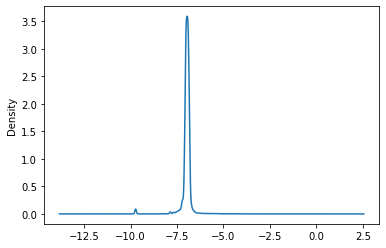

In [ ]:
df_0['info'].plot.kde();

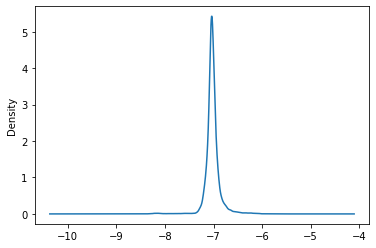

In [ ]:
df_0['pred'].plot.kde();

In [ ]:
_df.memory_usage().sum()/1024**3

0.0002981424331665039

Fancy Indexing:

In [ ]:
arr = np.empty((8,4))

In [ ]:
for i in range(8):
    arr[i] = i

In [ ]:
arr

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.],
       [3., 3., 3., 3.],
       [4., 4., 4., 4.],
       [5., 5., 5., 5.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]])

In [ ]:
arr[[4, 3, 0, 6]]

array([[4., 4., 4., 4.],
       [3., 3., 3., 3.],
       [0., 0., 0., 0.],
       [6., 6., 6., 6.]])

In [ ]:
arr[[-3, -5, -7]]

array([[5., 5., 5., 5.],
       [3., 3., 3., 3.],
       [1., 1., 1., 1.]])

In [ ]:
arr = np.arange(32).reshape((8,4))

In [ ]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31]])

In [ ]:
test_eq(arr[[1, 5, 7, 2], [0, 3, 1, 2]] , [arr[o] for o in list(zip([1, 5, 7, 2], [0, 3, 1, 2]))])

In [ ]:
arr[[1, 5, 7, 2]]

array([[ 4,  5,  6,  7],
       [20, 21, 22, 23],
       [28, 29, 30, 31],
       [ 8,  9, 10, 11]])

In [ ]:
arr[[1, 5, 7, 2]][:, [0, 3, 1, 2]]

array([[ 4,  7,  5,  6],
       [20, 23, 21, 22],
       [28, 31, 29, 30],
       [ 8, 11,  9, 10]])

In [ ]:
ind = [[0,3,1,2], [2,1,3,0], [0,1,2,3], [3,1,2,0]]
ind

[[0, 3, 1, 2], [2, 1, 3, 0], [0, 1, 2, 3], [3, 1, 2, 0]]

In [ ]:
arr[[1, 5, 7, 2]][ :, ind ]

array([[[ 4,  7,  5,  6],
        [ 6,  5,  7,  4],
        [ 4,  5,  6,  7],
        [ 7,  5,  6,  4]],

       [[20, 23, 21, 22],
        [22, 21, 23, 20],
        [20, 21, 22, 23],
        [23, 21, 22, 20]],

       [[28, 31, 29, 30],
        [30, 29, 31, 28],
        [28, 29, 30, 31],
        [31, 29, 30, 28]],

       [[ 8, 11,  9, 10],
        [10,  9, 11,  8],
        [ 8,  9, 10, 11],
        [11,  9, 10,  8]]])

In [ ]:
arr[[1, 5, 7, 2]][[0, 3, 1, 2], :]

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [20, 21, 22, 23],
       [28, 29, 30, 31]])

Rearrange columns:

In [ ]:
a = array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

change it to 

In [ ]:
array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

by applying the permutation

0 -> 0 

1 -> 4

2 -> 1

3 -> 3

4 -> 2

In [ ]:
permutation = [0,4,1,3,2]

In [ ]:
idx = np.empty_like(permutation)

In [ ]:
idx

array([0, 4, 1, 3, 2])

In [ ]:
idx[permutation] = np.arange(len(permutation))

In [ ]:
idx

array([0, 2, 4, 3, 1])

In [ ]:
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

In [ ]:
a[:,idx]

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

In [ ]:
a[:] = a[:,idx] # in-place modifcation of a

In [ ]:
a

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])